# Aspect-Based Sentiment Analysis with Born Classifier

### 1. Reading the dataset

In [1]:
import pandas as pd

In [2]:
df_orig=pd.read_csv("AWARE_Comprehensive.csv")

In [3]:
df_orig.shape

(11321, 14)

In [4]:
df_orig.head(2)

,domain,app,review_id,sentence_id,title,review,sentence,rating,is_opinion,category,term,from,to,sentiment
0,productivity,things-3,c9274c0a-a120-4e09-816b-7a8ba3a16634,00808934-e8b9-42fa-b37f-cfeac234bbdd,Difficult to update from Things 2,This new version of Things has an entirely dif...,This new version of Things has an entirely dif...,3,True,usability,new version,6.0,17.0,positive
1,productivity,notability,e633e20a-07c1-4a5e-80b1-b104b6cf6a61,00a8d4a4-9c8e-4d1c-9085-ffd1f62ae039,Great app,I have been using this app for over 3 years no...,All those contractors were blown away by how e...,5,False,NaN,NaN,NaN,NaN,NaN


Several reviews of my dataset do not contain opinions. I may want to delete them.

In [5]:
df_orig[df_orig.is_opinion==False].shape

(720, 14)

In [6]:
df=df_orig[df_orig.is_opinion==True]
print(df.shape)

(10601, 14)


There are still several NaNs, which can be deleted without losing too many rows of the dataset. 

In [7]:
df=df.dropna()
print(df.shape)

(6824, 14)


Verify if the dataset is balanced.

In [8]:
print(f"Positive reviews: {df[df.sentiment=="positive"].shape[0]}\nNegative reviews: {df[df.sentiment=="negative"].shape[0]}")
print(f"(Check dataset shape: {df.shape[0]==df[df.sentiment=="positive"].shape[0]+df[df.sentiment=="negative"].shape[0]})")

Positive reviews: 3337
Negative reviews: 3487
(Check dataset shape: True)


### 2. Data preprocessing

In [9]:
from tqdm import tqdm
import spacy
nlp = spacy.load('en_core_web_sm')

In [10]:
lemmatized_docs = []
# lemmatized_docs is a list that will containing only the lemmas of some tokens (according to their part of speech).
# This list will be used to train the Born Classifier.

lemma_dictionary={}
# In the lemma_dictionary, keys will be the lemmas for each term in the reviews and values will be lists of tuples containing the token,
# its part of speech, the index of the review it belongs to and the index of the sentence it appears in.

sents=[]
# sents will be a list of all the sentences present in the reviews of the dataset
# (the index of the review is associated with its sentences).

sent_count=-1
review_count=-1

slicing=3000 # the number can be modified!!!

for text in tqdm(df["review"][:slicing]): 
    content=nlp(text)
    tokens = []
    review_count+=1
    for sent in content.sents:
        sent_count+=1
        sents.append((review_count, sent))
        for token in sent:
            pos=token.pos_
            # I keep only tokens that are ADJECTIVES, ADVERBS, NOUNS, VERBS or PRONOUNS.
            # Also, in order to include negations, I keep tokens whose part of speech is "PART" (standing for "particle") and whose lemma is "not".
            if pos in {'ADJ', 'ADV', 'NOUN', 'VERB', 'PNOUN'} or (pos in {'PART'} and token.lemma_ =="not" ): 
                lemma = token.lemma_.lower()
                tokens.append(lemma)
                if lemma not in lemma_dictionary:
                    lemma_dictionary[lemma]=[]
                lemma_dictionary[lemma].append((str(token).lower(), pos, review_count, sent_count))
    lemmatized_docs.append(" ".join(tokens))
    

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [01:31<00:00, 32.91it/s]


In my dataset, each review can be either positive or negative:

In [11]:
df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [12]:
y= []
# I want a list of "positive" and "negative" according to the sentiment of each review
for k in df.sentiment:
    if k=="positive":
        y.append("positive")
    else:
        y.append("negative")

y=y[:slicing]

### 3. Vectorization

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

I shall vectorize the documents according to the *Term Frequency - Inverse Document Frequency* of the lemmatized tokens

In [14]:
vectorizer=TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(lemmatized_docs).toarray() # Use fit_transform!

# This is the list of all the features in alphabetical order
features = vectorizer.get_feature_names_out()

### 4. Classification with Born Classifier

In [15]:
from bornrule import BornClassifier
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [17]:
bc = BornClassifier()
bc.fit(X_train, y_train)
bc_pred = bc.predict(X_test)

### 5. Evaluation and Confusion matrix

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [19]:
print(classification_report(y_test, bc_pred, zero_division=0))

              precision    recall  f1-score   support

    negative       0.62      0.68      0.65       437
    positive       0.67      0.61      0.64       463

    accuracy                           0.64       900
   macro avg       0.64      0.64      0.64       900
weighted avg       0.65      0.64      0.64       900



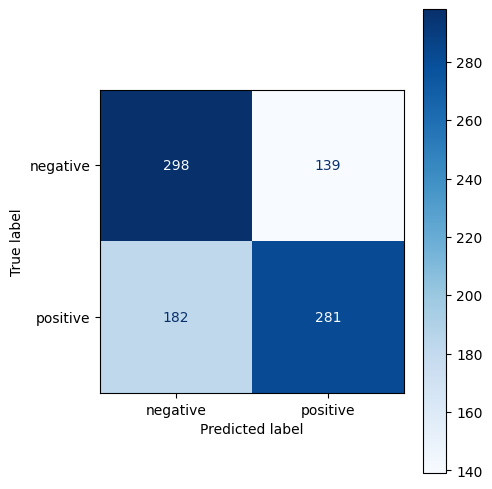

In [22]:
cm = confusion_matrix(y_test, bc_pred)
display = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
fig, ax = plt.subplots(figsize=(5, 5))
display.plot(ax=ax, cmap='Blues')
plt.tight_layout()
plt.show()

### 6. Explanation

Global explanation

In [23]:
E = pd.DataFrame(bc.explain(), columns=["neg", "pos"])
E["features"]=list(features) # Create a new column for the features

In [24]:
E.head()

,neg,pos,features
0,0.004895,0.000000,00am
1,0.000000,0.006626,0hitting
2,0.001775,0.000990,10
3,0.000000,0.000000,100
4,0.000000,0.004274,1000


Local explanation

In [25]:
# As an example, take the first review
E_local = pd.DataFrame(bc.explain(X[0].reshape(1, -1)), index=features, columns=["neg", "pos"])

In [26]:
# Select only the features that have some weight for the classification of the first review
E_local[(E_local["neg"]!=0.000000) | (E_local["pos"]!=0.000000)]

,neg,pos
aesthetic,0.001033,0.000637
award,0.000322,0.000225
bloat,0.004022,0.000000
come,0.000084,0.000094
design,0.000528,0.000706
different,0.000151,0.000176
entirely,0.002331,0.000915
lot,0.000048,0.000052
minimalist,0.000018,0.000016
new,0.000281,0.000235


### 7. Finding candidate aspects

In this case, I shall consider as aspects all the features extracted from the global explanation of Born Classifier having part of speech="NOUN" in at least one review of the original dataset.

In [27]:
noun=[False] * E.shape[0]
for i, f in enumerate(tqdm(features)):
    if f in lemma_dictionary:
        for tuple in lemma_dictionary[f]:
            if tuple[1]=="NOUN":
                noun[i]=True
                break # To make the search faster
E["noun"]=noun

100%|██████████| 5116/5116 [00:00<00:00, 209242.81it/s]


In [28]:
E.head()

,neg,pos,features,noun
0,0.004895,0.000000,00am,False
1,0.000000,0.006626,0hitting,False
2,0.001775,0.000990,10,False
3,0.000000,0.000000,100,False
4,0.000000,0.004274,1000,False


Theses are the most influential **negative aspects**, that is all aspects whose negative weight is equal to or above the third quartile.

In [29]:
import numpy as np

In [32]:
neg_quart = np.quantile(list(E[E.neg!=0.0].neg), 0.75)
print(f"Value of third quartile: {neg_quart}")
negative_aspects=E[(E.neg>=neg_quart) & (E.noun==True)]

Value of third quartile: 0.004889783473803613


In [33]:
negative_aspects.sort_values("neg", ascending=False)

,neg,pos,features,noun
306,0.021449,0.00000,asking,True
3667,0.019439,0.00596,refund,True
2370,0.019386,0.00000,interval,True
4980,0.019299,0.00000,watermark,True
3078,0.017566,0.00000,opportunity,True
...,...,...,...,...
1699,0.004895,0.00000,flashlight,True
2171,0.004890,0.00000,imac,True
3559,0.004890,0.00000,radar,True
571,0.004890,0.00000,bucket,True


Theses are the most influential **positive aspects**, that is all aspects whose positive weight is equal to or above the third quartile.

In [34]:
pos_quart = np.quantile(list(E[E.pos!=0.0].pos), 0.75)
print(f"Value of third quartile: {pos_quart}")
positive_aspects=E[(E.pos>=pos_quart) & (E.noun==True)]

Value of third quartile: 0.005309068635964847


In [35]:
positive_aspects.sort_values("pos", ascending=False)

,neg,pos,features,noun
1061,0.005213,0.020384,cute,True
2484,0.000000,0.019942,kudo,True
1704,0.000000,0.018637,flawless,True
172,0.000000,0.017261,ala,True
3873,0.000000,0.016701,routine,True
...,...,...,...,...
1950,0.000000,0.005330,grievance,True
1884,0.002535,0.005325,glass,True
177,0.000000,0.005316,alerady,True
4512,0.000000,0.005316,technicaial,True


### 8. Associating each aspect to a portion of the text 

Negative aspects

In [36]:
neg_sentences=[]
neg_test=[]
for f in tqdm(list(negative_aspects.features)):
    for tuple in lemma_dictionary[f]:
        if tuple[1]=="NOUN":
            sentence_index=tuple[3] # find the sentence that includes that aspect
            review_index=tuple[2] # find the review that includes that aspect
            neg_sentences.append(str(sents[sentence_index][1]))
            neg_test.append(df.iloc[review_index].sentiment) # find the relative sentiment

  0%|          | 0/441 [00:00<?, ?it/s]

100%|██████████| 441/441 [00:00<00:00, 897.38it/s]


In [37]:
print(f"Negative: {neg_test.count("negative")}\nPositive: {neg_test.count("positive")}")

Negative: 1995
Positive: 654


Positive aspects

In [39]:
pos_sentences=[]
pos_test=[]
for f in tqdm(list(positive_aspects.features)):
    for tuple in lemma_dictionary[f]:
        if tuple[1]=="NOUN":
            index=tuple[3] # find the sentence that includes that aspect
            review_index=tuple[2] # find the review that includes that aspect
            pos_sentences.append(str(sents[index][1]))
            pos_test.append(df.iloc[review_index].sentiment) # find the relative sentiment

100%|██████████| 507/507 [00:00<00:00, 975.30it/s]


In [40]:
print(f"Negative: {pos_test.count("negative")}\nPositive: {pos_test.count("positive")}")

Negative: 636
Positive: 2441


### 9. Sentiment prediction

Negative aspects

In [41]:
vectorized_text = vectorizer.transform(neg_sentences).toarray() # Note: this time it is only "transform"
neg_final_pred = bc.predict(vectorized_text)

In [42]:
print(classification_report(neg_test, neg_final_pred, zero_division=0))

              precision    recall  f1-score   support

    negative       0.80      0.85      0.83      1995
    positive       0.45      0.36      0.40       654

    accuracy                           0.73      2649
   macro avg       0.63      0.61      0.61      2649
weighted avg       0.72      0.73      0.72      2649



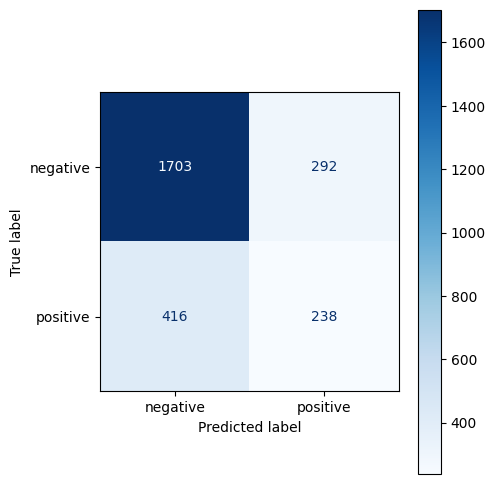

In [49]:
cm = confusion_matrix(neg_test, neg_final_pred)
display = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
fig, ax = plt.subplots(figsize=(5, 5))
display.plot(ax=ax, cmap='Blues')
plt.tight_layout()
plt.show()

Positive aspects

In [44]:
vectorized_text = vectorizer.transform(pos_sentences).toarray() # Note: this time it is only "transform"
pos_final_pred = bc.predict(vectorized_text)

In [45]:
print(classification_report(pos_test, pos_final_pred, zero_division=0))

              precision    recall  f1-score   support

    negative       0.46      0.33      0.38       636
    positive       0.84      0.90      0.87      2441

    accuracy                           0.78      3077
   macro avg       0.65      0.61      0.62      3077
weighted avg       0.76      0.78      0.77      3077



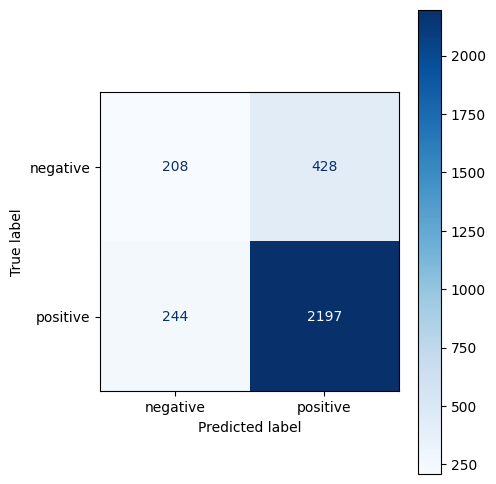

In [50]:
cm = confusion_matrix(pos_test, pos_final_pred)
display = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
fig, ax = plt.subplots(figsize=(5, 5))
display.plot(ax=ax, cmap='Blues')
plt.tight_layout()
plt.show()

### Concluding remarks

An example of wrong POS taging by SpaCy: the adjective "flawless" is annotated as 'NOUN'

In [47]:
from spacy.displacy import render

In [48]:
print(f"From review in position 205: \"{sents[1833][1]}\"")
render(sents[1833][1])

From review in position 205: "I use macOS and find the syncing between the Mac and iPhone flawless."
